## Segmentation code for clickstream data

In [57]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

#from helper_functions import do_pca, scree_plot, plot_components, pca_results
from IPython import display
#import test_code2 as t

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#!pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user helper

# Read Data

In [49]:
# Read dataset and look at top records

df = pd.read_csv('e-shop clothing 2008.csv', delimiter=";")
df.head(5)

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [50]:
#Check the number of rows and columns and their types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

In [51]:
# Convert categorical variables to string
cat_vars = ['year', 'month', 'day', 'country', 'session ID',
               'page 1 (main category)', 'page 2 (clothing model)', 'colour',
               'location', 'model photography', 'price 2', 'page']
df[cat_vars] = df[cat_vars].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  object
 1   month                    165474 non-null  object
 2   day                      165474 non-null  object
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  object
 5   session ID               165474 non-null  object
 6   page 1 (main category)   165474 non-null  object
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  object
 9   location                 165474 non-null  object
 10  model photography        165474 non-null  object
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  object
 13  page                     165474 non-null  object
dtypes: int64(2), object(

In [52]:
# Check properties of numeric fields
df.describe()

,order,price
count,165474.000000,165474.000000
mean,9.817476,43.802507
std,13.478411,12.548131
min,1.000000,18.000000
25%,2.000000,33.000000
50%,6.000000,43.000000
75%,12.000000,52.000000
max,195.000000,82.000000


In [53]:
# Feature Engineering
from scipy.stats import mode 
df2 = df.groupby(['country','page 1 (main category)','page 2 (clothing model)']).agg(
                                                                             median_no_of_clicks_per_session=('order', 'median'),
                                                                             min_no_of_clicks_per_session=('order', 'max'),
                                                                             max_no_of_clicks_per_session=('order', 'min'),
                                                                             median_price=('price', 'median'),
                                                                             min_price=('price', 'max'),
                                                                             max_price=('price', 'min'),
                                                                             total_number_of_sessions =('session ID', pd.Series.nunique),
                                                                             most_frequent_day=('day', lambda x: mode(x)[0][0]),
                                                                             most_frequent_colour=('colour', lambda x: mode(x)[0][0]),
                                                                             most_frequent_location=('location', lambda x: mode(x)[0][0]),
                                                                             most_frequent_photo_type=('model photography', lambda x: mode(x)[0][0]),
                                                                             most_frequent_price_type =('price 2', lambda x: mode(x)[0][0]),
                                                                             most_frequent_page_number =('page', lambda x: mode(x)[0][0])
                                                                            )

df2

median_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                    
1       3                      C30                                                  2.0   
        4                      P17                                                  2.0   
10      1                      A1                                                   2.0   
                               A11                                                  2.0   
                               A12                                                  3.0   
...                                                                                 ...   
9       4                      P77                                                 18.0   
                               P78                                                  6.5   
                               P80                                                 96.0   
                               P82                                                 17.5   
                               P9                                                   3.0   

                                                        min_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 3   
10      1                      A1                                                  2   
                               A11                                                 3   
                               A12                                                 5   
...                                                                              ...   
9       4                      P77                                                18   
                               P78                                                95   
                               P80                                                96   
                               P82                                                18   
                               P9                                                  4   

                                                        max_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 1   
10      1                      A1                                                  2   
                               A11                                                 1   
                               A12                                                 1   
...                                                                              ...   
9       4                      P77                                                18   
                               P78                                                 1   
                               P80                                                96   
                               P82                                                17   
                               P9                                                  1   

                                                        median_price  \
country page 1 (main category) page 2 (clothing model)                 
1       3                      C30                                28   
        4                      P17                                38   
10      1                      A1                                 28   
                               A11                                62   
                               A12                                38   
...                                                              ...   
9     

# One hot encoding - to convert categorical data to continuous

In [55]:
# One hot encoding - to convert categorical data to continuous

cat_vars = ['most_frequent_day',
           'most_frequent_colour', 'most_frequent_location',
           'most_frequent_photo_type', 'most_frequent_price_type',
           'most_frequent_page_number']
df2[cat_vars] = df2[cat_vars].astype(str)
df3 = pd.get_dummies(df2)

df3.head(5)

median_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                    
1       3                      C30                                                  2.0   
        4                      P17                                                  2.0   
10      1                      A1                                                   2.0   
                               A11                                                  2.0   
                               A12                                                  3.0   

                                                        min_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 3   
10      1                      A1                                                  2   
                               A11                                                 3   
                               A12                                                 5   

                                                        max_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                                 2   
        4                      P17                                                 1   
10      1                      A1                                                  2   
                               A11                                                 1   
                               A12                                                 1   

                                                        median_price  \
country page 1 (main category) page 2 (clothing model)                 
1       3                      C30                                28   
        4                      P17                                38   
10      1                      A1                                 28   
                               A11                                62   
                               A12                                38   

                                                        min_price  max_price  \
country page 1 (main category) page 2 (clothing model)                         
1       3                      C30                             28         28   
        4                      P17                             38         38   
10      1                      A1                              28         28   
                               A11                             62         62   
                               A12                             38         38   

                                                        total_number_of_sessions  \
country page 1 (main category) page 2 (clothing model)                             
1       3                      C30                                             1   
        4                      P17                                             1   
10      1                      A1                                              1   
                               A11                                             2   
                               A12                                             5   

                                                        most_frequent_day_1  \
country page 1 (main category) page 2 (clothing model)                        
1       3                      C30                                        0   
        4                      P17                                        0   
10      1                      A1                                         0   
                               A11                                        0   
                               A12                     

In [56]:
# Standardizing


con_vars = ['median_no_of_clicks_per_session', 'min_no_of_clicks_per_session',
           'max_no_of_clicks_per_session', 'median_price', 'min_price',
           'max_price', 'total_number_of_sessions']

scaler = StandardScaler()
df3[con_vars]=scaler.fit_transform(df3[con_vars])
df3.head(5)

median_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                    
1       3                      C30                                            -0.784923   
        4                      P17                                            -0.784923   
10      1                      A1                                             -0.784923   
                               A11                                            -0.784923   
                               A12                                            -0.686829   

                                                        min_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                         -0.740009   
        4                      P17                                         -0.715043   
10      1                      A1                                          -0.740009   
                               A11                                         -0.715043   
                               A12                                         -0.665109   

                                                        max_no_of_clicks_per_session  \
country page 1 (main category) page 2 (clothing model)                                 
1       3                      C30                                         -0.445811   
        4                      P17                                         -0.550030   
10      1                      A1                                          -0.445811   
                               A11                                         -0.550030   
                               A12                                         -0.550030   

                                                        median_price  \
country page 1 (main category) page 2 (clothing model)                 
1       3                      C30                         -1.197785   
        4                      P17                         -0.367561   
10      1                      A1                          -1.197785   
                               A11                          1.624976   
                               A12                         -0.367561   

                                                        min_price  max_price  \
country page 1 (main category) page 2 (clothing model)                         
1       3                      C30                      -1.197785  -1.197785   
        4                      P17                      -0.367561  -0.367561   
10      1                      A1                       -1.197785  -1.197785   
                               A11                       1.624976   1.624976   
                               A12                      -0.367561  -0.367561   

                                                        total_number_of_sessions  \
country page 1 (main category) page 2 (clothing model)                             
1       3                      C30                                     -0.254235   
        4                      P17                                     -0.254235   
10      1                      A1                                      -0.254235   
                               A11                                     -0.248735   
                               A12                                     -0.232237   

                                                        most_frequent_day_1  \
country page 1 (main category) page 2 (clothing model)                        
1       3                      C30                                        0   
        4                      P17                                        0   
10      1                      A1                                         0   
                               A11                                        0   
                               A12                     

In [9]:
#!pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user opencv-python
#from helper_functions import do_pca,pca_results

# PCA

In [58]:
# PCA

# Loop Function to identify number of principal components that explain atleast 85% of the variance
for comp in range(3, df3.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(df3)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.85:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
Final_PCA.fit(df3)
cluster_df=Final_PCA.transform(df3)


num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

Using 15 components, we can explain 0.8521121438333593% of the variability in the original data.


# K means




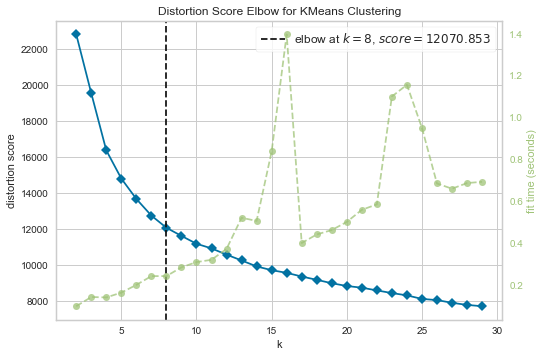

In [34]:
# Elbow Method for K means
from sklearn.cluster import KMeans
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state =10)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Optimal number of clusters based on gap statistic: [29.0]


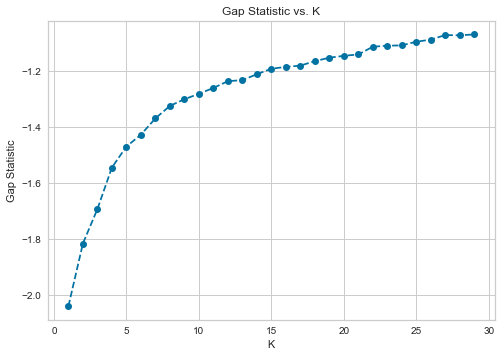

In [35]:
# Gap Statistic for K means


def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, random_state =10)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)

score_g, df = optimalK(cluster_df, nrefs=5, maxClusters=30)

plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

df2 = df[df.gap == df.gap.max()]
print('Optimal number of clusters based on gap statistic:', df2['clusterCount'].tolist())

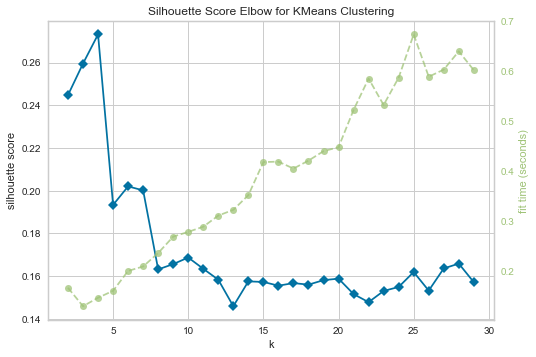

Optimal number of clusters based on silhouette score: [4]


In [36]:
# Silhouette Score for K means

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state =10)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

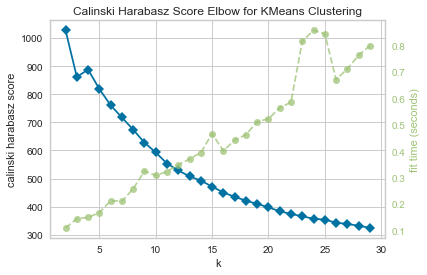

Optimal number of clusters based on calinski harabasz: [2]


In [59]:
# Calinski Harabasz Score for K means

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state =10)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True, locate_elbow=False)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on calinski harabasz:', df4['centers'].tolist())

Optimal number of clusters based on DB score: [4]


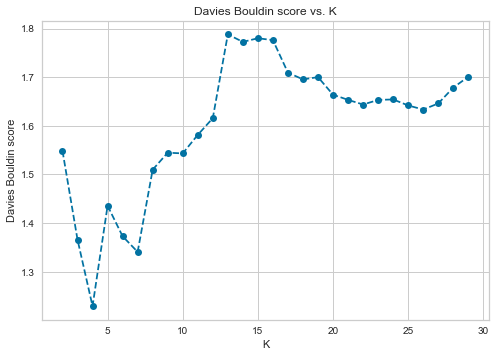

In [38]:
# Davies Bouldin score for K means

from sklearn.metrics import davies_bouldin_score 

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center,random_state =10)

    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(cluster_df)
    
    # Calculate Silhoutte Score

    score = davies_bouldin_score(cluster_df, model)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_kmeans_score(cluster_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');


df3 = pd.DataFrame(centers,columns=['centers'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.min()]
print('Optimal number of clusters based on DB score:', df4['centers'].tolist())

In [61]:
# K means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
# Fit K-Means
kmeans_1 = KMeans(n_clusters=4, random_state= 10)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(cluster_df)
# Calculate cluster validation metrics
score_kemans_s = silhouette_score(cluster_df, kmeans_1.labels_, metric='euclidean')
score_kemans_c = calinski_harabasz_score(cluster_df, kmeans_1.labels_)
score_kemans_d = davies_bouldin_score(cluster_df, predictions)


print('Silhouette Score: %.4f' % score_kemans_s)
print('Calinski Harabasz Score: %.4f' % score_kemans_c)
print('Davies Bouldin Score: %.4f' % score_kemans_d)

Silhouette Score: 0.2732
Calinski Harabasz Score: 887.8355
Davies Bouldin Score: 1.2291


In [ ]:
def gap_stat_kmeans(data = cluster_df,nrefs=3,k=4):
    # Gap Stat
    refDisps = np.zeros(nrefs)
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
    for i in range(nrefs):

        # Create new random reference set
        randomReference = np.random.random_sample(size=cluster_df.shape)

        # Fit to it
        km = KMeans(k, random_state =10)
        km.fit(randomReference)

        refDisp = km.inertia_
        refDisps[i] = refDisp

    # Fit cluster to original data and create dispersion
    km = KMeans(k)
    km.fit(cluster_df)

    origDisp = km.inertia_

    # Calculate gap statistic
    score_g = np.log(np.mean(refDisps)) - np.log(origDisp)
    return score_g

score_kemans_g = gap_stat_kmeans(cluster_df,3,4)
print('Gap Statistic Score: %.4f' % score_kemans_g)

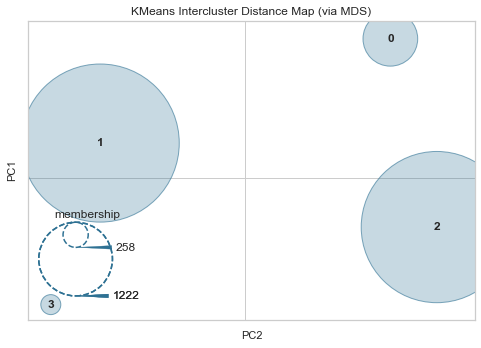

In [41]:
# Inter cluster distance map


from yellowbrick.cluster import InterclusterDistance


# Instantiate the clustering model and visualizer

visualizer = InterclusterDistance(kmeans_1)

visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Heirarchical Clustering

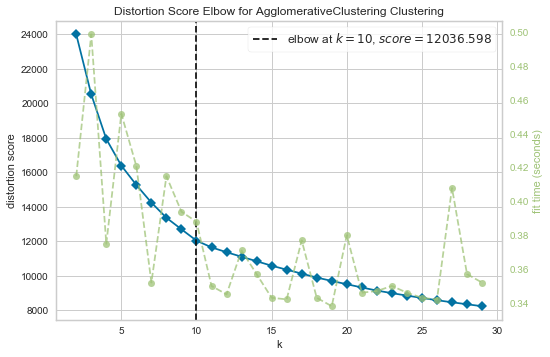

In [38]:
# Elbow Method for Heirarchical Clustering
from sklearn.cluster import MiniBatchKMeans
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

# define dataset
# define the model


model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

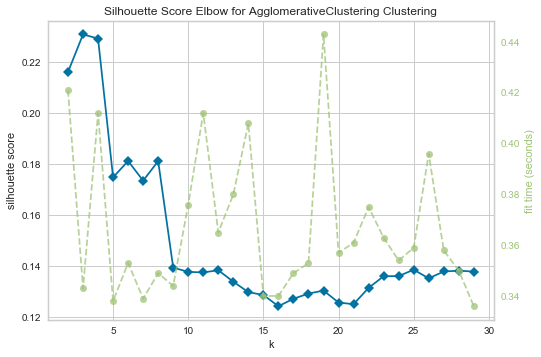

Optimal number of clusters based on silhouette score: [3]


In [39]:
# Silhouette Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True, locate_elbow=False)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

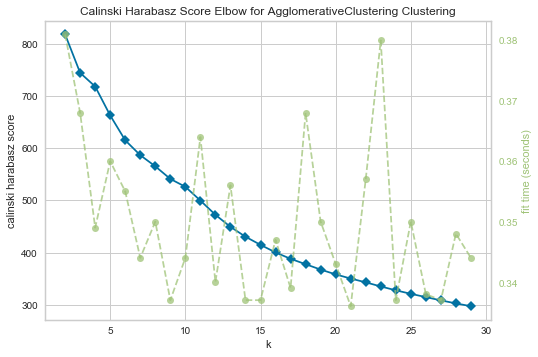

Optimal number of clusters based on silhouette score: [2]


In [40]:
# Calinski Harabasz Score for Hierarchical Clustering

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True, locate_elbow=False)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


df3 = pd.DataFrame(visualizer.k_values_,columns=['centers'])
df3['scores'] = visualizer.k_scores_
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of clusters based on silhouette score:', df4['centers'].tolist())

Optimal number of clusters based on DB score: [8]


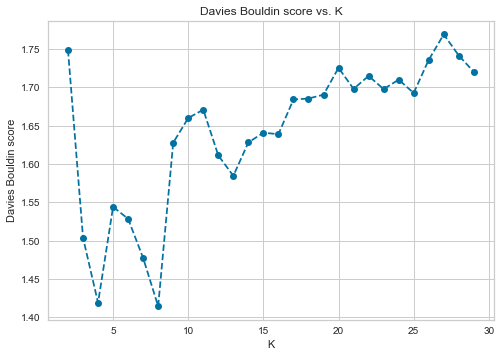

In [44]:
# Davies Bouldin score for Hierarchical Clustering

from sklearn.metrics import davies_bouldin_score 

def get_AG_clustering_score(data, center):
    '''
    returns the AG_clustering score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit AG_clustering to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the AG_clustering model fit to the data
    '''
    #instantiate AG_clustering
    AG_clustering = AgglomerativeClustering(n_clusters= center)

    # Then fit the model to your data using the fit method
    model = AG_clustering.fit_predict(cluster_df)
    
    # Calculate Silhoutte Score

    score = davies_bouldin_score(cluster_df, model)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_AG_clustering_score(cluster_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');


df3 = pd.DataFrame(centers,columns=['centers'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.min()]
print('Optimal number of clusters based on DB score:', df4['centers'].tolist())

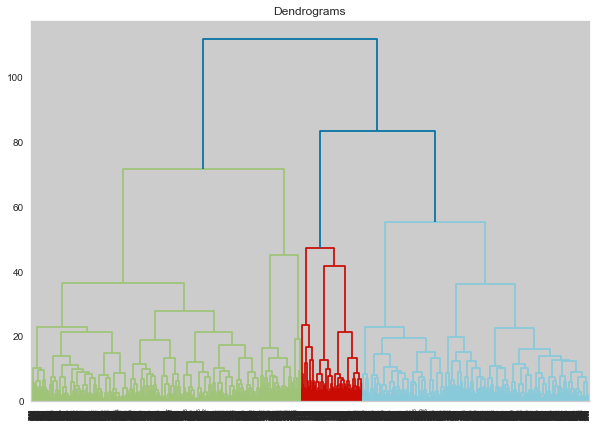

In [42]:
# Dendrogram for Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster_df, method='ward'))

In [62]:
# Agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot

# define the model
model = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat = model.fit(cluster_df)
yhat_2 = model.fit_predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)


# Calculate cluster validation metrics

score_AGclustering_s = silhouette_score(cluster_df, yhat.labels_, metric='euclidean')

score_AGclustering_c = calinski_harabasz_score(cluster_df, yhat.labels_)

score_AGclustering_d = davies_bouldin_score(cluster_df, yhat_2)



print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)

print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.2291
Calinski Harabasz Score: 718.8155
Davies Bouldin Score: 1.4191


# DBSCAN

1.9335816413107338


<Figure size 360x360 with 0 Axes>

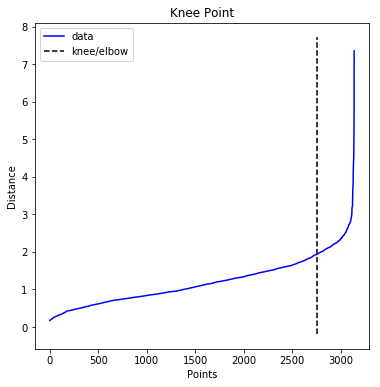

In [28]:
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(cluster_df)
distances, indices = neighbors.kneighbors(cluster_df)
distances = np.sort(distances[:,10], axis=0)

from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

Optimal number of min_samples based on silhouette score: [18]


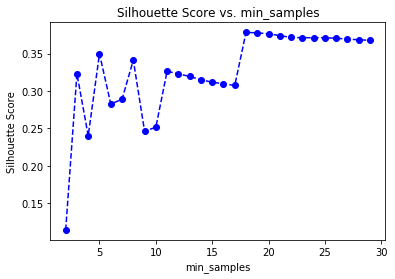

In [29]:
# Silhouette Score for DBSCAN

from sklearn.metrics import silhouette_score 
from sklearn.cluster import DBSCAN

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Silhouette Score for DBSCAN
    '''
    #instantiate kmeans
    dbscan = DBSCAN(eps= 1.9335816413107338, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(cluster_df)
    
    # Calculate Silhoutte Score

    score = silhouette_score(cluster_df, model.labels_, metric='euclidean')
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(cluster_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. min_samples');

df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())

Optimal number of min_sample based on Calinski Harabasz score: [29]


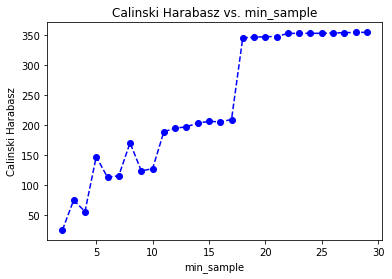

In [30]:
# Calinski Harabasz for DBSCAN

from sklearn.metrics import calinski_harabasz_score  

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit dbscan to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Calinski Harabasz score for the dbscan model fit to the data
    '''
    #instantiate dbscan
    dbscan = DBSCAN(eps= 1.9335816413107338, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(cluster_df)
    
    # Calculate Silhoutte Score

    score = calinski_harabasz_score(cluster_df, dbscan.labels_)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(cluster_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_sample');
plt.ylabel('Calinski Harabasz');
plt.title('Calinski Harabasz vs. min_sample');

df3 = pd.DataFrame(centers,columns=['min_sample'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_sample based on Calinski Harabasz score:', df4['min_sample'].tolist())

Optimal number of min_samples based on DB score: [2]


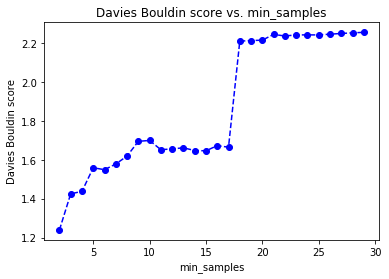

In [31]:
# Davies Bouldin score for DBSCAN

from sklearn.metrics import davies_bouldin_score 

def get_dbscan_score(data, center):
    '''
    returns the dbscan score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit dbscan to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the dbscan model fit to the data
    '''
    #instantiate dbscan
    dbscan = DBSCAN(eps= 1.9335816413107338, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit_predict(cluster_df)
    
    # Calculate Silhoutte Score

    score = davies_bouldin_score(cluster_df, model)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(cluster_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. min_samples');


df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.min()]
print('Optimal number of min_samples based on DB score:', df4['min_samples'].tolist())

In [55]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define dataset
# define the model
model = DBSCAN(eps=1.9335816413107338, min_samples= 18)

# rule of thumb for min_samples: 2*len(cluster_df.columns)

# fit model and predict clusters
yhat = model.fit_predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)


# Calculate cluster validation metrics

score_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')

score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)

score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)



print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)


Silhouetter Score: 0.3782
Calinski Harabasz Score: 345.2103
Davies Bouldin Score: 2.2108


# GMM Clustering

In [42]:
# BIC for GMM

from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        gmm.fit(cluster_df)
        score.append((cov,n_comp,gmm.bic(cluster_df)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
112,full,26,10171.280409


In [43]:
# Silhouette Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov,random_state = 10)
        model = gmm.fit(cluster_df)
        model_2 = model.predict(cluster_df)
        score_s = silhouette_score(cluster_df, model_2, metric='euclidean')
        score.append((cov,n_comp,score_s))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Silhouette_Score']
score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]
score_2.head(n=2)

,Covariance_Type,N_Components,Silhouette_Score
28,tied,2,0.320604


In [44]:
# Calinski Harabasz Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(cluster_df)
        model_2 = model.predict(cluster_df)
        score_c = calinski_harabasz_score(cluster_df, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Calinski_Harabasz_Score']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=5)

,Covariance_Type,N_Components,Calinski_Harabasz_Score
2,spherical,4,878.787589


In [46]:
# Davies Bouldin Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(cluster_df)
        model_2 = model.predict(cluster_df)
        score_d = davies_bouldin_score(cluster_df, model_2)
        score.append((cov,n_comp,score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Davies_Bouldin_Score']
score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.max()]
score_2.head(n=2)

,Covariance_Type,N_Components,Davies_Bouldin_Score
90,full,8,3.84953


In [48]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define the model
model = GaussianMixture(n_components= 26,covariance_type= "full", random_state = 10)
# fit the model
model.fit(cluster_df)
# assign a cluster to each example
yhat = model.predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)



# Calculate cluster validation score

score_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')

score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)

score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)



print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)

Silhouetter Score: 0.0697
Calinski Harabasz Score: 191.3066
Davies Bouldin Score: 2.4507
